# Foodgroup for Phenix

**Objective** : <br>
Predict the foodgroup (12 groups) of a product of Phenix <br>
Remark : cannot run without the file `data/all_foodsCommandes_2017.csv` (1.02Go, contains all orders of Phenix) <br>
Remark : cannot run without the file `data/openfoodfacts_groupeAlim_2.csv` (31Mo, assigns a foodgroup to a OpenFoodFacts' product) <br>

**Main results** : <br>
- using names and naive bayes : 88.9% of accuracy (87.2% for a simpler model)

**Outputs** : <br>
- `data/clf_names_nb.sav` (90Mo, model which predicts foodgroups from names, 88.9% accuracy)
- `data/clf_names_nb_light.sav` (16.4Mo, model which predicts foodgroups from names, 87.2% accuracy)


In [1]:
import numpy as np
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
#import unidecode
#from collections import Counter
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline #to put countvectorizer and naivebayes together
import pickle
import itertools

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

pd.options.display.max_rows = 100

## Opening files

In [3]:
# Phenix database
all_foodsCommandes_2017 = pd.read_csv("../../data/all_foodsCommandes_2017.csv", sep = ';', 
                                      encoding = 'UTF-8',dtype = {'EAN': str, 'Produit_Nom' : str})

# Open Food Facts
## For each product, a food group has been given
# This file is an output from 1-Foodgroup for OpenFoodFacts.ipynb
openfoodfacts_foodgroup = pd.read_csv("../../data/openfoodfacts_groupeAlim_2.csv", sep = ';', 
                                      encoding = 'UTF-8', dtype = {'EAN': str, 'product_name' : str})

In [4]:
openfoodfacts_foodgroup.head()

,product_name,EAN,foodgroup
0,Vitória crackers,0000000000017,Produits gras sucrés salés
1,Sauce Sweety chili 0%,0000000000123,Matières grasses ajoutées
2,Salade de carottes râpées,0000000000949,Matières grasses ajoutées
3,Fromage blanc aux myrtilles,0000000000970,Produits laitiers (hors fromage)
4,Baguette parisien,0000000001137,Plats préparés


In [5]:
print(openfoodfacts_foodgroup.shape)
print(all_foodsCommandes_2017.shape)

(518912, 3)
(3188676, 31)


In [6]:
# Only keeping unique products (based on the name and the EAN code)
unique_foodsCommandes_2017 = all_foodsCommandes_2017[['EAN', 'Produit_Nom']].drop_duplicates()
# Beware : an EAN may redirect to several names

In [7]:
# Join with EAN
common_EAN = unique_foodsCommandes_2017.merge(openfoodfacts_foodgroup, how = 'inner')

print(common_EAN.shape) #118713 x 4

(118713, 4)


In [8]:
common_EAN.head()

,EAN,Produit_Nom,product_name,foodgroup
0,3242274006556,SALADE LIBANAISE 320G SODEBO,Salade & Compagnie - Libanaise,Légumes
1,3242274006556,SALADE LIBANAISE 320G,Salade & Compagnie - Libanaise,Légumes
2,3242274006556,"SALADE LIBANAISE,SODEBO,320G",Salade & Compagnie - Libanaise,Légumes
3,3242274006556,"SALADE LIBANAISE,,320G",Salade & Compagnie - Libanaise,Légumes
4,3242274006556,SALADE LIBANAISE SODEBO 320G,Salade & Compagnie - Libanaise,Légumes


## Machine learning

In [9]:
# Food groups
list_foodgroup = np.unique(common_EAN['foodgroup'])
print("There are %.0f food groups." %len(list_foodgroup))

There are 12 food groups.


### Naive Bayes

We have 12 food groups, called $C_i$. So, given a product name $n$, the aim is to predict the probability of belonging to a class $C_i$ : $\mathbb{P}(C = C_i | N = n)$.

Thanks to Bayes rules, we get : 
$$ \mathbb{P}(C = C_i | N = n) = \dfrac{\mathbb{P}(N = n | C = C_i) \times \mathbb{P}(C = C_i)}{\mathbb{P}(N = n)}$$

We will consider that for all names $n$, $\mathbb{P}(N = n) =$ constant. Consequently, we have to explicit two calculus.

First of all, $\mathbb{P}(C = C_i)$ is approximated by the proportion of products belonging to the group $C_i$.

Then, we will consider that a name, $n$, is composed of words $w$ which are independant and identically distributed (strong assumption but it simplifies the calculation). Therefore, $$\mathbb{P}(N = n | C = C_i) = \prod_{w_k \in n} \mathbb{P}(W = w_k | C = C_i)$$.

In [11]:
# Train and test sets
train_x, test_x, train_y, test_y = model_selection.train_test_split(common_EAN['Produit_Nom'], common_EAN['foodgroup'])

print("Among the %.0f products of the database of Phenix, only %.0f are useful for this methodology because there are in Open Food Facts' database.\n \
      \tIn the training dataset, there are %.0f observations.\n\tIn the test dataset, there are %.0f observations." % 
      (unique_foodsCommandes_2017.shape[0], common_EAN.shape[0], train_x.shape[0], test_x.shape[0]))

Among the 184660 products of the database of Phenix, only 118713 are useful for this methodology because there are in Open Food Facts' database.
       	In the training dataset, there are 89034 observations.
	In the test dataset, there are 29679 observations.


In [12]:
?CountVectorizer

In [13]:
?naive_bayes.MultinomialNB

In [22]:
# Firstly, let's create a pipeline which will contains all hyper-parameters
pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = 1,
                                         ngram_range = (1,3))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = 1e-3))
    ])

# Fit the model
pipeline.fit(train_x, train_y)

# Prediction
predictions = pipeline.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = predictions)
print('Accuracy of naive bayes model : %.2f%%' % (100 * accuracy_model))
# 88.9% : french + min_df = 1, ngram:1-3, alpha = 1e-3

Accuracy of naive bayes model : 88.87%


In [30]:
# Let's create a simpler model, which needs less memory
pipeline_light = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = 2,
                                         ngram_range = (1,2))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = 1e-3))
    ])

# Fit the model
pipeline_light.fit(train_x, train_y)

# Prediction
predictions = pipeline_light.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = predictions)
print('Accuracy of simple naive bayes model : %.2f%%' % (100 * accuracy_model))
# 87.2% : french + min_df = 2, ngram:1-2, alpha = 1e-3

Accuracy of simple naive bayes model : 87.19%


Let's optimize the hyperparameters of the naive bayes

Estimation for alpha = 0.0


C:\Users\Mehdi\Anaconda3\envs\py35\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Estimation for alpha = 0.0001
Estimation for alpha = 0.001
Estimation for alpha = 0.01
Estimation for alpha = 0.1
Estimation for alpha = 0.2
Estimation for alpha = 0.3
Estimation for alpha = 0.4
Estimation for alpha = 0.5
Estimation for alpha = 0.6
Estimation for alpha = 0.7
Estimation for alpha = 0.8
Estimation for alpha = 0.9
Estimation for alpha = 1.0
     alpha  training_accuracy  validation_accuracy
0   0.0000              99.70                88.20
1   0.0001              99.58                88.43
2   0.0010              99.49                88.53
3   0.0100              99.22                88.59
4   0.1000              98.68                88.39
5   0.2000              98.34                88.02
6   0.3000              98.06                87.53
7   0.4000              97.69                86.98
8   0.5000              97.39                86.56
9   0.6000              96.98                86.31
10  0.7000              96.56                85.78
11  0.8000              96.18  

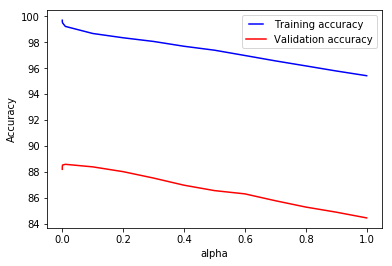

In [15]:
# Optimization for alpha
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_alpha = [x for x in np.linspace(start = 0, stop = 1, num = 11)]
list_alpha = sorted(list_alpha + [1e-4, 1e-3, 1e-2])

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_alpha : 
    
    print("Estimation for alpha = %s" % hyp)
    
    pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = 1,
                                         ngram_range = (1,3))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = hyp))
    ])

    # Learning 
    pipeline.fit(training_x, training_y)

    # predict the labels on validation dataset
    training_pred = pipeline.predict(training_x)
    valid_pred = pipeline.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'alpha' : list_alpha,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_alpha, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_alpha, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('alpha')
plt.show()    

Estimation for max_ngram = 1
Estimation for max_ngram = 2
Estimation for max_ngram = 3
Estimation for max_ngram = 4
Estimation for max_ngram = 5
   max_ngram  training_accuracy  validation_accuracy
0          1              92.26                84.74
1          2              98.76                88.03
2          3              99.48                88.32
3          4              99.63                88.31
4          5              99.65                88.31


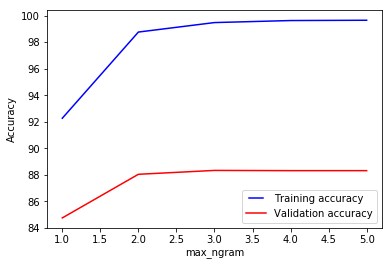

In [16]:
# Optimization for max_ngram (ngram_range)
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_max_ngram = [1,2,3,4,5]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_max_ngram : 
    
    print("Estimation for max_ngram = %s" % hyp)
    
    pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = 1,
                                         ngram_range = (1,hyp))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = 1e-3))
    ])

    # Learning 
    pipeline.fit(training_x, training_y)

    # predict the labels on validation dataset
    training_pred = pipeline.predict(training_x)
    valid_pred = pipeline.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'max_ngram' : list_max_ngram,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_max_ngram, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_max_ngram, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('max_ngram')
plt.show()    

Estimation for min_df = 1
Estimation for min_df = 2
Estimation for min_df = 3
Estimation for min_df = 4
Estimation for min_df = 5
Estimation for min_df = 6
Estimation for min_df = 7
Estimation for min_df = 8
Estimation for min_df = 9
Estimation for min_df = 10
   min_df  training_accuracy  validation_accuracy
0       1              99.49                88.60
1       2              94.70                86.97
2       3              92.17                86.03
3       4              90.56                85.26
4       5              89.36                84.62
5       6              88.51                84.13
6       7              87.73                83.65
7       8              87.09                83.36
8       9              86.66                83.14
9      10              86.19                82.91


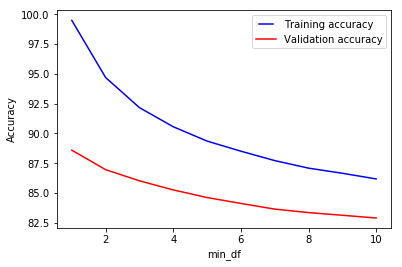

In [17]:
# Optimization for min_df
training_accuracy = []
valid_accuracy = []

# Hyperparameter's range
list_min_df = [1,2,3,4,5,6,7,8,9,10]

# Training and validation sets
training_x, valid_x, training_y, valid_y = model_selection.train_test_split(train_x, train_y, test_size = 0.2)

for hyp in list_min_df : 
    
    print("Estimation for min_df = %s" % hyp)
    
    pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')), 
                                         min_df = hyp,
                                         ngram_range = (1,3))),
    ('naive_bayes', naive_bayes.MultinomialNB(alpha = 1e-3))
    ])

    # Learning 
    pipeline.fit(training_x, training_y)

    # predict the labels on validation dataset
    training_pred = pipeline.predict(training_x)
    valid_pred = pipeline.predict(valid_x)

    # Accuracy
    training_acc = 100 * accuracy_score(y_true = training_y, y_pred = training_pred)
    valid_acc = 100 * accuracy_score(y_true = valid_y, y_pred = valid_pred)
        
    training_accuracy.append(training_acc)
    valid_accuracy.append(valid_acc)
    
results = pd.DataFrame({'min_df' : list_min_df,
            'training_accuracy' : np.round(training_accuracy, 2),
            'validation_accuracy' : np.round(valid_accuracy, 2)})
print(results)

# Plotting the results
line1, = plt.plot(list_min_df, training_accuracy, 'b', label="Training accuracy")
line2, = plt.plot(list_min_df, valid_accuracy, 'r', label="Validation accuracy")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})

plt.ylabel('Accuracy')
plt.xlabel('min_df')
plt.show()    

According to these 1-dimensional analysis, one gets the following intuitions : 
- alpha : the lower, the better ; 
- n_gram : greater than 2; 
- min_df : the lower the better

Let's use a random grid search

In [19]:
# Optimization with a random grid search

# Alpha smoothing parameters
alpha = [0, 1e-4, 1e-3]

#N-grams
ngram_range = [(1,1), (1,2), (1,3)]

# Minimal number of occurences
min_df = [1,2]

# Stopwords
#vect_stopwords = [set(stopwords.words('french')), None]

# Create the random grid
# Note : follow the notation : MODEL__PARAM ! 
random_grid = {'naive_bayes__alpha': alpha,
               'count_vectorizer__ngram_range' : ngram_range,
               'count_vectorizer__min_df': min_df}

In [20]:
# Use the random grid to search for best hyperparameters

# Firstly, let's create a pipeline which will contains all hyper-parameters
pipeline_to_optimize = Pipeline([
    ('count_vectorizer', CountVectorizer(stop_words = set(stopwords.words('french')))),
    ('naive_bayes', naive_bayes.MultinomialNB())
    ])

# All parameters to tune =)
# pipeline_to_optimize.get_params().keys()

# Random search of parameters, using cv fold cross validation, 
# search across different combinations, and use all available cores
random_grid_search = model_selection.RandomizedSearchCV(estimator = pipeline_to_optimize, 
                                                   param_distributions = random_grid,
                                                   n_iter = 12, cv = 5,
                                                   verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
random_grid_search.fit(train_x, train_y)

# Evaluate the best hyperparameters
print(random_grid_search.best_params_)

# Prediction
predictions = random_grid_search.predict(test_x)
accuracy_model = accuracy_score(y_true = test_y, y_pred = predictions)
print('Accuracy of the best naive bayes model : %.2f%%' % (100 * accuracy_model))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.9min finished


{'count_vectorizer__min_df': 1, 'naive_bayes__alpha': 0.001, 'count_vectorizer__ngram_range': (1, 3)}
Accuracy of the best naive bayes model : 88.87%


In [21]:
cv_results = pd.DataFrame(random_grid_search.cv_results_)
cv_results.sort_values('rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_count_vectorizer__min_df,param_count_vectorizer__ngram_range,param_naive_bayes__alpha,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,8.616261,1.138956,0.883000,0.994957,1,"(1, 3)",0.001,"{'count_vectorizer__min_df': 1, 'naive_bayes__...",1,0.883661,...,0.879324,0.995100,0.884596,0.994819,0.882141,0.994974,0.231200,0.115774,0.002117,0.000089
3,6.363316,0.938677,0.881293,0.987870,1,"(1, 2)",0.001,"{'count_vectorizer__min_df': 1, 'naive_bayes__...",2,0.881976,...,0.877527,0.988136,0.881957,0.987856,0.880512,0.987983,0.284565,0.077566,0.002277,0.000177
4,6.633501,0.973149,0.878507,0.993373,1,"(1, 2)",0,"{'count_vectorizer__min_df': 1, 'naive_bayes__...",3,0.878214,...,0.875056,0.993710,0.880328,0.993205,0.877479,0.993669,0.270122,0.060517,0.002239,0.000264
11,8.784102,1.128341,0.869151,0.946119,2,"(1, 3)",0.001,"{'count_vectorizer__min_df': 2, 'naive_bayes__...",4,0.869792,...,0.864555,0.946452,0.869377,0.946649,0.868547,0.945924,0.278359,0.283254,0.002854,0.000491
6,8.534347,1.198251,0.868185,0.949064,2,"(1, 3)",0.0001,"{'count_vectorizer__min_df': 2, 'naive_bayes__...",5,0.868669,...,0.864274,0.949555,0.868142,0.949682,0.866861,0.948760,0.164134,0.210741,0.002838,0.000597
5,6.150292,1.276677,0.867938,0.946692,2,"(1, 2)",0.0001,"{'count_vectorizer__min_df': 2, 'naive_bayes__...",6,0.868445,...,0.863376,0.947154,0.867692,0.947014,0.866300,0.946500,0.198166,0.422017,0.003438,0.000550
7,8.415181,1.070089,0.866017,0.952145,2,"(1, 3)",0,"{'count_vectorizer__min_df': 2, 'naive_bayes__...",7,0.866480,...,0.861916,0.952784,0.865727,0.952644,0.864558,0.951890,0.191308,0.042605,0.003108,0.000642
9,2.987241,0.523905,0.849664,0.921996,1,"(1, 1)",0.001,"{'count_vectorizer__min_df': 1, 'naive_bayes__...",8,0.850140,...,0.847540,0.923258,0.848374,0.922319,0.847649,0.921301,0.021384,0.006859,0.002645,0.000733
1,3.188686,0.586268,0.846373,0.923540,1,"(1, 1)",0.0001,"{'count_vectorizer__min_df': 1, 'naive_bayes__...",9,0.847614,...,0.844115,0.924817,0.845117,0.923821,0.843436,0.922957,0.072316,0.027558,0.002966,0.000715
8,3.133037,0.525313,0.846048,0.898154,2,"(1, 1)",0.001,"{'count_vectorizer__min_df': 2, 'naive_bayes__...",10,0.847221,...,0.842487,0.900093,0.845847,0.898522,0.843492,0.897533,0.156912,0.023871,0.003069,0.001128


### TF-IDF 
TODO

## Prediction for products out of Open Food Facts

In [24]:
def get_foodGroup(EAN, Produit_Nom = None, model_matching = pipeline, EAN_group_df = openfoodfacts_foodgroup) : 
    '''
    -- Input --
    EAN : EAN code, string
    Produit_Nom : name of the product, string
    EAN_group_df : database of OFF
    model_matching : model which predicts a foodgroup, may be a pipeline =) 
    
    -- Output --
    food_group : the group of the product, string
    '''
    
    # Search of the EAN in the database
    food_group = EAN_group_df[EAN_group_df['EAN'] == EAN] #dataframe with 0 or 1 row
    
    # Firstly, if the EAN is in the database, it is easy
    if food_group.shape[0] != 0 :
        food_group = food_group.iloc[0]['foodgroup']
    else : #there is not this EAN in the database, we have to use the name of the product
        food_group = model_matching.predict([Produit_Nom])[0]
        
    return food_group
        

In [26]:
# If the EAN is correct
get_foodGroup(EAN = "3503910000087")

'Produits gras sucrés salés'

In [27]:
# If the EAN is incorrect
get_foodGroup(EAN = "3503910000t087", Produit_Nom = "pizza")

'Plats préparés'

In [31]:
# Selected model
print(pipeline)
print(pipeline_light)

# Save the model to disk
filename_pipeline = '../../data/clf_names_nb.sav'
pickle.dump(pipeline, open(filename_pipeline, 'wb'))

filename_pipeline_light = '../../data/clf_names_nb_light.sav'
pickle.dump(pipeline_light, open(filename_pipeline_light, 'wb'))

Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), preprocessor=None,
        stop_words...e, vocabulary=None)), ('naive_bayes', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])
Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=2,
        ngram_range=(1, 2), preprocessor=None,
        stop_words...e, vocabulary=None)), ('naive_bayes', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])
